# Project Name and Description

## Contents
1. Frame the problem  and look at the big picture
2. Get the data
3. Explore and visualize the data to gain insights
4. Prepare the data to better expose the underlying patterns to machine learning algorithm
5. Explore many modesl; Select a model and train it
6. Fine-tune the model
7. Present your solution
8. Launch, monitor and maintain your system



# 1. Frame the problem
Estimate the price of a house based on a number of predictors.


In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pandas.plotting import scatter_matrix
from scipy import stats
from scipy.stats import kruskal, pearsonr


/tmp/ipykernel_5934/3215895653.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Sklearn imports
import joblib
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline, make_pipeline, make_union
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint

import sklearn
sklearn.set_config(display='diagram')

In [3]:
# Custom-made utilities
from src.data_retrieval import fetch_data
from src.utilities import save_fig
from src.feature_engineering import ClusterSimilarity

In [4]:
# Some plotting settings
plt.rc('font', size=11)
plt.rc('axes', labelsize=10, titlesize=10)
plt.rc('legend', fontsize=10)
plt.rc('xtick', labelsize=9)
plt.rc('ytick', labelsize=9)

# 2. Getting the data

In [5]:
# Load data
df_full = df = fetch_data()
target = 'median_house_value'  # the name of the target variable
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# 3. Explore and visualize the data to gain insights

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
df['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [8]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


'images/distributions of numerical variables.png'

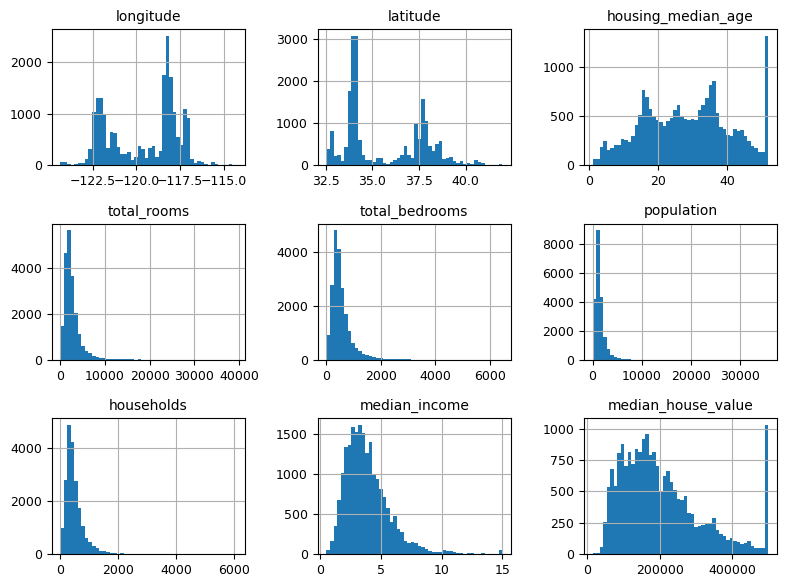

In [9]:
df.hist(bins=50, figsize=(8, 6))
save_fig("distributions of numerical variables")

## Train Test Split
Domain knowledge: because `median income` is important in predicting the target, the train-test split must be stratified on that feature.

In [10]:
# Make income category (temporary)
income_cat = pd.cut(df['median_income'],
                    bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                    right=False,
                    labels=[1, 2, 3, 4, 5])

'images/income categories.png'

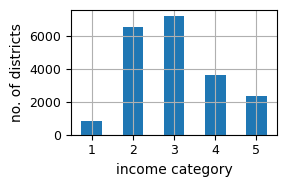

In [11]:
# Vizualise the categories
income_cat.value_counts().sort_index().plot.bar(rot=0, grid=True, figsize=(3,2))
plt.xlabel("income category")
plt.ylabel("no. of districts")
save_fig("income categories")

## Stratified split

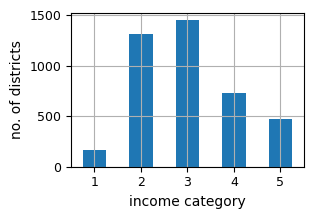

In [12]:
# Stratified split
train_set, test_set = train_test_split(df_full, test_size=0.2, stratify=income_cat, random_state=42)

# See the stratified split for yourself
income_cat_testset = pd.cut(test_set['median_income'], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], right=False, labels=[1, 2, 3, 4, 5])
income_cat_testset.value_counts().sort_index().plot.bar(rot=0, grid=True, figsize=(3,2))
plt.xlabel("income category"); plt.ylabel("no. of districts");

# 3.2 Explore the data

In [13]:
# 1. Put away the test set
test_set.to_csv("data/test_set.csv")

# 2. Also, save the train set
train_set.to_csv("data/train_set.csv")

# 2. Make an exploration subset
df = Xtrain = housing = train_set.copy()  # full because len(train_set) is small

'images/California.png'

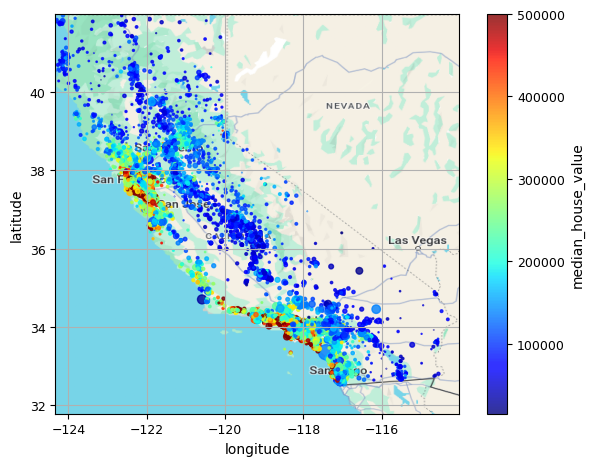

In [14]:
# Visualize on the map
extent = [-124.34,-114.02, 31.78,41.99]  # photo extent = geo-coords

df.plot(kind='scatter', x='longitude', y='latitude', grid=True,
        s=df['population'] / 300, c=target, cmap='jet', colorbar=True, alpha=0.8,
        legend=True, sharex=True)
plt.axis(extent)

pn = plt.imread("images/[-124.34,-114.02,31.78,41.99].png")  # (553, 444, 4)
plt.imshow(pn, extent=extent)
save_fig("California")

### Experiment with DBSCAN on ['longitude', 'latitude']

In [15]:
# Experiment with DBSCAN
dbscan = DBSCAN(eps=0.25, min_samples=150, metric='euclidean')
df['cluster'] = dbscan.fit_predict(df[['longitude', 'latitude']])
df['cluster'].value_counts()

cluster
 1    7148
 0    3802
-1    2113
 2    1360
 4    1271
 3     610
 5     208
Name: count, dtype: int64

'images/DBSCAN.png'

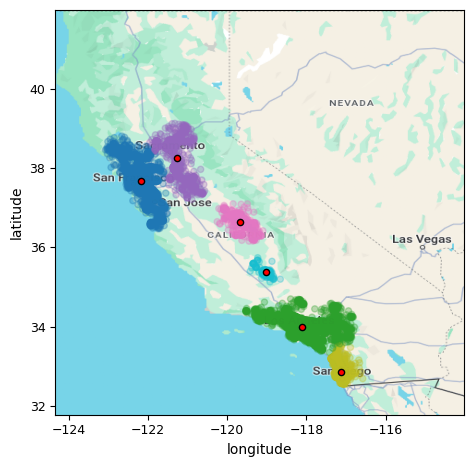

In [16]:
# Visualize the DBSCAN clusters
ax = plt.axes()

pn = plt.imread("images/[-124.34,-114.02,31.78,41.99].png")  # (553, 444, 4)
extent = [-124.34,-114.02, 31.78,41.99]  # photo extent
ax.imshow(pn, extent=extent)
plt.axis(extent)

# Plot the clusters
df[df['cluster'] != -1].plot(kind='scatter', x='longitude', y='latitude', c='cluster', 
                                            alpha=0.3, cmap='tab10', colorbar=False, ax=ax)

# Draw the cluster centroids
df_centroids = df[['longitude', 'latitude', 'cluster']].groupby('cluster').mean().drop(-1, axis=0).sort_index()
df_centroids.plot(kind='scatter', x='longitude', y='latitude', c='red', edgecolor='k', ax=ax)

save_fig("DBSCAN")

In [17]:
# Add a new feature: distance from the respective centroid

def func(row: pd.Series):
    if row['cluster'] == -1:
        return np.nan
    return ((row[['longitude', 'latitude']] - df_centroids.loc[row['cluster']])**2).sum() ** (1/2)

df["distance_from_centroid"] = df.apply(func, axis=1)
df.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,cluster,distance_from_centroid
17449,-122.29,38.00,16.0,4986.0,1081.0,2805.0,1016.0,4.0250,173200.0,NEAR BAY,0,0.341508
17064,-118.01,33.86,29.0,2307.0,452.0,1218.0,402.0,3.4306,194200.0,<1H OCEAN,1,0.160812
17341,-121.56,38.58,32.0,2070.0,561.0,2046.0,523.0,1.9426,82300.0,INLAND,2,0.439921
7160,-121.94,38.37,17.0,7973.0,1591.0,2899.0,1502.0,2.8357,120100.0,INLAND,0,0.734263
20462,-118.10,34.08,21.0,1349.0,352.0,1188.0,330.0,2.5000,182100.0,<1H OCEAN,1,0.087449
1293,-121.62,39.75,20.0,1173.0,261.0,523.0,258.0,1.0625,92800.0,INLAND,-1,NaN
1034,-118.63,34.18,33.0,5252.0,760.0,2041.0,730.0,6.7977,389700.0,<1H OCEAN,1,0.561185
15293,-117.70,33.50,4.0,7474.0,1037.0,2969.0,1007.0,8.7591,434700.0,<1H OCEAN,1,0.635177
5007,-118.53,34.03,40.0,4350.0,763.0,1551.0,665.0,7.0318,500001.0,<1H OCEAN,1,0.430586
19122,-117.66,34.08,33.0,3659.0,590.0,1773.0,615.0,3.9227,157200.0,INLAND,1,0.449630


In [18]:
# Kruskal-Wallis test for dependence cluster->tagret (H0: no dependence)

alpha = 0.05
samples = [e[0] for e in df[['cluster', target]].groupby('cluster').agg(list).values]
res = kruskal(*samples)
pvalue = res.pvalue
print(f'p-value = {pvalue}\nreject H0?: {"yes" if pvalue < alpha else "no"}')

p-value = 0.0
reject H0?: yes


Kruskal-Wallis test showed that there is a strong dependence between the cluster and target feature.
We will make one-hot features out of the 'cluster' feature.

In [19]:
# Check Pearson's correlation
df['reverse_distance'] = (df['distance_from_centroid'].max() - df['distance_from_centroid']).fillna(0)
X,Y = df['reverse_distance'], df[target]

statistic, pvalue = pearsonr(X,Y)
statistic

0.23708130717633408

'images/correlation matrix.png'

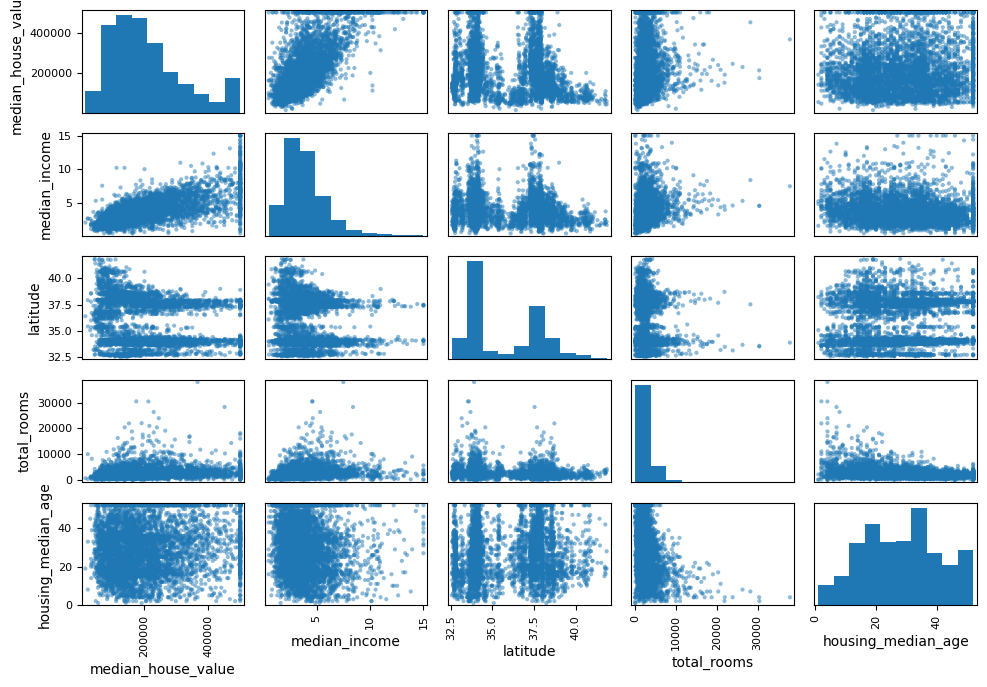

In [20]:
# Visualize the correlations
selected_features = [target, 'median_income', 'latitude', 'total_rooms', 'housing_median_age']
scatter_matrix(df[selected_features].sample(5_000), figsize=(10,7))
save_fig("correlation matrix")

median_house_value
500001.0    775
162500.0     97
137500.0     96
112500.0     84
187500.0     73
225000.0     70
350000.0     66
87500.0      61
150000.0     58
275000.0     53
100000.0     51
67500.0      44
175000.0     44
125000.0     42
250000.0     41
Name: count, dtype: int64

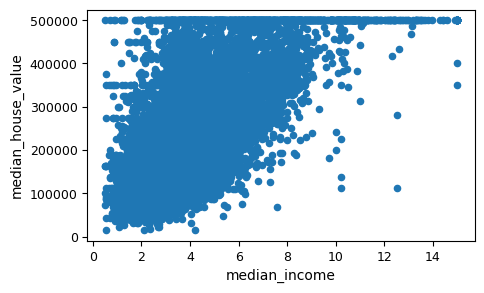

In [21]:
# Plot 'median_income' vs target
df.plot(kind='scatter', x='median_income', y=target, figsize=(5,3))
df[target].value_counts().head(15)

### Feature engineering: ratios


In [22]:
df["rooms_per_house"] = df['total_rooms'] / df['households']
df["bedrooms_ratio"] = df['total_bedrooms'] / df['total_rooms']
df["people_per_house"] = df['population'] / df['households']
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,cluster,distance_from_centroid,reverse_distance,rooms_per_house,bedrooms_ratio,people_per_house
17449,-122.29,38.00,16.0,4986.0,1081.0,2805.0,1016.0,4.0250,173200.0,NEAR BAY,0,0.341508,1.147173,4.907480,0.216807,2.760827
17064,-118.01,33.86,29.0,2307.0,452.0,1218.0,402.0,3.4306,194200.0,<1H OCEAN,1,0.160812,1.327868,5.738806,0.195925,3.029851
17341,-121.56,38.58,32.0,2070.0,561.0,2046.0,523.0,1.9426,82300.0,INLAND,2,0.439921,1.048760,3.957935,0.271014,3.912046
7160,-121.94,38.37,17.0,7973.0,1591.0,2899.0,1502.0,2.8357,120100.0,INLAND,0,0.734263,0.754417,5.308256,0.199548,1.930093
20462,-118.10,34.08,21.0,1349.0,352.0,1188.0,330.0,2.5000,182100.0,<1H OCEAN,1,0.087449,1.401232,4.087879,0.260934,3.600000


In [23]:
# Compute correlations
df.select_dtypes(include='float').corr()[target].sort_values(key=abs, ascending=False)

median_house_value        1.000000
median_income             0.687369
bedrooms_ratio           -0.253567
reverse_distance          0.237081
rooms_per_house           0.151071
latitude                 -0.142290
total_rooms               0.132973
housing_median_age        0.107244
households                0.066395
longitude                -0.049937
total_bedrooms            0.049495
population               -0.025966
people_per_house         -0.022334
distance_from_centroid   -0.019840
Name: median_house_value, dtype: float64

### Feature Engineering: Gaussian RBF kernel for 'house_median_age'

gaussian_rbf_similarity_to_peak_a -0.119
gaussian_rbf_similarity_to_peak_b -0.095
gaussian_rbf_similarity_to_peak_c 0.023


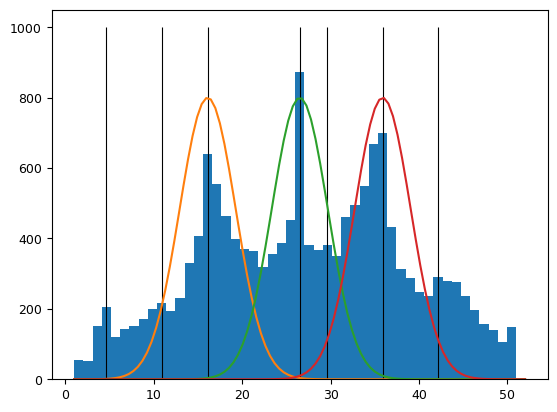

In [24]:

# explore the peaks in 'house age'
from src import get_peaks

col = 'housing_median_age'
a = df.loc[df[col] < df[col].max(), col]

peaks, bins = get_peaks(a, n_peaks=7, return_bins=True)

plt.hist(a, bins=bins)
plt.vlines(peaks, ymin=0, ymax=1000, color='k', linewidth=0.8)

# Select 3 highest peaks
peaks = sorted(peaks[:3])

gamma = 0.001  # chosen by hand based on persons correlation

# this will be needed for plotting
xx = np.linspace(df[col].min(), df[col].max(), num=100).reshape(-1,1)

for i,peak in enumerate(peaks):
    df[f"gaussian_rbf_similarity_to_peak_{'abc'[i]}"] = rbf_kernel(df[[col]], [[peak]], gamma=gamma)
    print(f"gaussian_rbf_similarity_to_peak_{'abc'[i]}", 
          round(pearsonr(df[f"gaussian_rbf_similarity_to_peak_{'abc'[i]}"], df[target]).statistic, 3))
    
    # plot the Gaussian RBF
    plt.plot(xx.ravel(), rbf_kernel(xx, [[peak]], gamma=0.05).ravel() * 800)


### Feature engineering: "digitalize" 'ocean_proximity'

In [25]:
# Replacing a categorical feature with numerical / embedding
categorical_feature = 'ocean_proximity'
df[categorical_feature] = pd.Categorical(df[categorical_feature],
                                        categories=['ISLAND', 'NEAR OCEAN', 'NEAR BAY', '<1H OCEAN', 'INLAND'],
                                        ordered=True).codes
df.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,cluster,distance_from_centroid,reverse_distance,rooms_per_house,bedrooms_ratio,people_per_house,gaussian_rbf_similarity_to_peak_a,gaussian_rbf_similarity_to_peak_b,gaussian_rbf_similarity_to_peak_c
17449,-122.29,38.00,16.0,4986.0,1081.0,2805.0,1016.0,4.0250,173200.0,2,0,0.341508,1.147173,4.907480,0.216807,2.760827,0.999989,0.895218,0.673112
17064,-118.01,33.86,29.0,2307.0,452.0,1218.0,402.0,3.4306,194200.0,3,1,0.160812,1.327868,5.738806,0.195925,3.029851,0.846790,0.993873,0.953560
17341,-121.56,38.58,32.0,2070.0,561.0,2046.0,523.0,1.9426,82300.0,4,2,0.439921,1.048760,3.957935,0.271014,3.912046,0.776718,0.970425,0.984937
7160,-121.94,38.37,17.0,7973.0,1591.0,2899.0,1502.0,2.8357,120100.0,4,0,0.734263,0.754417,5.308256,0.199548,1.930093,0.999198,0.913341,0.699736
20462,-118.10,34.08,21.0,1349.0,352.0,1188.0,330.0,2.5000,182100.0,3,1,0.087449,1.401232,4.087879,0.260934,3.600000,0.976316,0.969980,0.801007
1293,-121.62,39.75,20.0,1173.0,261.0,523.0,258.0,1.0625,92800.0,4,-1,NaN,0.000000,4.546512,0.222506,2.027132,0.984937,0.958370,0.776718
1034,-118.63,34.18,33.0,5252.0,760.0,2041.0,730.0,6.7977,389700.0,3,1,0.561185,0.927496,7.194521,0.144707,2.795890,0.751662,0.958889,0.991649
15293,-117.70,33.50,4.0,7474.0,1037.0,2969.0,1007.0,8.7591,434700.0,3,1,0.635177,0.853504,7.422046,0.138748,2.948361,0.863716,0.602187,0.361554
5007,-118.53,34.03,40.0,4350.0,763.0,1551.0,665.0,7.0318,500001.0,3,1,0.430586,1.058095,6.541353,0.175402,2.332331,0.564954,0.833862,0.983297
19122,-117.66,34.08,33.0,3659.0,590.0,1773.0,615.0,3.9227,157200.0,4,1,0.449630,1.039051,5.949593,0.161246,2.882927,0.751662,0.958889,0.991649


### Quick and dirty linear regression

In [26]:
df["log_median_income"] = np.log(df['median_income'])
df["log_bedrooms_ratio"] = np.log(df['bedrooms_ratio'] + 0.001)
df["log_rooms_per_house"] = np.log(df['rooms_per_house'])

df.select_dtypes(include=[np.number]).corr()[target].sort_values(key=abs, ascending=False)

median_house_value                   1.000000
median_income                        0.687369
log_median_income                    0.649521
ocean_proximity                     -0.388158
log_bedrooms_ratio                  -0.325685
bedrooms_ratio                      -0.253567
reverse_distance                     0.237081
log_rooms_per_house                  0.236386
rooms_per_house                      0.151071
latitude                            -0.142290
total_rooms                          0.132973
gaussian_rbf_similarity_to_peak_a   -0.118615
housing_median_age                   0.107244
cluster                             -0.106315
gaussian_rbf_similarity_to_peak_b   -0.095284
households                           0.066395
longitude                           -0.049937
total_bedrooms                       0.049495
population                          -0.025966
gaussian_rbf_similarity_to_peak_c    0.023368
people_per_house                    -0.022334
distance_from_centroid            

In [27]:
# select the good predictors
predictors = ['log_median_income', 'ocean_proximity', 'log_bedrooms_ratio', 'reverse_distance', 'log_rooms_per_house', 'latitude',
              'gaussian_rbf_similarity_to_peak_a', 'housing_median_age', 
              'gaussian_rbf_similarity_to_peak_b', 'gaussian_rbf_similarity_to_peak_c',]

# drop the capped values
mask = (df['log_median_income'] < df['log_median_income'].max()) & (df[target] < df[target].max())
df = df[mask]

# drop nan values
df.dropna(subset=['log_bedrooms_ratio'], inplace=True)

# standerdise
X = (df[predictors] - df[predictors].mean(axis=0)) / df[predictors].std(axis=0)

# add the one hots (cluster)
oh = pd.get_dummies(df['cluster'], drop_first=True, prefix="cluster").astype(float)
X = pd.concat([X, oh], axis=1)

#X.columns = X.columns.astype(str)
y = df[target]

# model OLS
md = LinearRegression().fit(X,y)
md.score(X,y)  # R squared

/tmp/ipykernel_5934/2555371183.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['log_bedrooms_ratio'], inplace=True)


0.5468274716659651

### Target Transformation
You get better results if you transform the target as well: log(y)

In [28]:
# Build an OLS model

md = TransformedTargetRegressor(LinearRegression(), 
                                   transformer=FunctionTransformer(np.log, inverse_func=np.exp))
md.fit(X, y)
md.score(X,y)  # R squared

0.5693180243121516

In [29]:
# View the weights
weights = pd.Series(md.regressor_.coef_, index=X.columns).round(2)
weights.sort_values(key=abs, ascending=False)

gaussian_rbf_similarity_to_peak_b    0.73
gaussian_rbf_similarity_to_peak_c   -0.69
gaussian_rbf_similarity_to_peak_a   -0.63
cluster_5                           -0.39
cluster_3                           -0.33
log_median_income                    0.32
cluster_0                            0.25
cluster_1                            0.17
housing_median_age                   0.14
ocean_proximity                     -0.13
cluster_4                           -0.13
log_bedrooms_ratio                   0.09
cluster_2                            0.07
latitude                            -0.06
reverse_distance                     0.04
log_rooms_per_house                  0.03
dtype: float64

In [30]:
# RMSE
ytrue = y
ypred = md.predict(X)

rmse = mean_squared_error(ytrue, ypred) ** (1/2)
rmse

64053.74138826746

# 4. Prepare the data to better expose the underlying patterns to machine learning algorithm
### Revert to the original train dataset

In [31]:
X_train = df = X = pd.read_csv("data/train_set.csv", index_col=0)
y_train = ytrue = y = X_train.pop(target)


In [32]:
# Imputation on the numerical features
df_num = df_numerical_features = df.select_dtypes(include=[np.number])

imputer = SimpleImputer(strategy='median').fit(df_numerical_features)
X_train_numerical_imputed = imputer.transform(df_numerical_features)
df_numerical_features_imputed = pd.DataFrame(X_train_numerical_imputed, 
                                             columns=df_numerical_features.columns,
                                             index=df_numerical_features.index)
imputer.statistics_

array([-118.5   ,   34.26  ,   29.    , 2126.5   ,  435.    , 1167.    ,
        410.    ,    3.5394])

### Custom Transformers

In [33]:
log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(df[['population']])

In [34]:
# Function Transformer with arguments

rbf_transformer_peak_a = FunctionTransformer(rbf_kernel,
                                             kw_args={'Y': [[peaks[0]]], 'gamma': 0.03})
age_similarity_peak_a = rbf_transformer_peak_a.transform(df[['housing_median_age']])

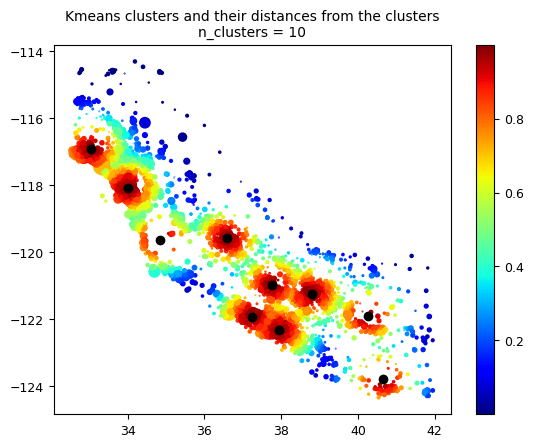

In [35]:
tr = ClusterSimilarity(n_clusters=10, gamma=1.0)
X_tr = X_similarities = tr.fit_transform(df[['latitude', 'longitude']])

plt.plot(*tr.cluster_centers_.T, 'ok')
plt.scatter(*df[['latitude', 'longitude']].T.values, c=X_tr.max(1), cmap='jet', s=df['population']/200)
plt.colorbar()
plt.title(f"Kmeans clusters and their distances from the clusters\nn_clusters = {X_tr.shape[1]}");

In [36]:
df_temp = pd.DataFrame(X_tr, columns=[f"cluster_{i+1}" for i in range(X_tr.shape[1])])
df_temp["target"] = y
corr = df_temp.corr()
corr.iloc[:, -1].sort_values(key=abs, ascending=False)

target        1.000000
cluster_1    -0.013869
cluster_9     0.013840
cluster_8     0.008094
cluster_5    -0.007156
cluster_3     0.006007
cluster_2     0.005574
cluster_6    -0.004167
cluster_10   -0.002655
cluster_7    -0.002280
cluster_4    -0.001587
Name: target, dtype: float64

### Transfromation Pipelines

In [37]:

num_attribs = df.select_dtypes(include=[np.number]).columns
cat_attribs = ['ocean_proximity']

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy='median')),
    ("standerdize", StandardScaler())
])

cat_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)

preprocessing_pipline = pl = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs)
])
# or like this:
preprocessing = preprocessing_pipline = pl = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object))
)

preprocessing

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('standerdize',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fbde8da6e60>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fbde8da6e30>)])

In [38]:
housing_prepared = X_preprocessed = preprocessing.fit_transform(df)
df_preprocessed = pd.DataFrame(X_preprocessed, columns=preprocessing.get_feature_names_out())
df_preprocessed.head()

,pipeline-1__longitude,pipeline-1__latitude,pipeline-1__housing_median_age,pipeline-1__total_rooms,pipeline-1__total_bedrooms,pipeline-1__population,pipeline-1__households,pipeline-1__median_income,pipeline-2__ocean_proximity_<1H OCEAN,pipeline-2__ocean_proximity_INLAND,pipeline-2__ocean_proximity_ISLAND,pipeline-2__ocean_proximity_NEAR BAY,pipeline-2__ocean_proximity_NEAR OCEAN
0,-1.357933,1.106289,-1.001846,1.067275,1.290928,1.204322,1.351657,0.082794,0.0,0.0,0.0,1.0,0.0
1,0.779852,-0.832261,0.031756,-0.148977,-0.200100,-0.181746,-0.252650,-0.231603,1.0,0.0,0.0,0.0,0.0
2,-0.993311,1.377873,0.270279,-0.256573,0.058282,0.541420,0.063508,-1.018654,0.0,1.0,0.0,0.0,0.0
3,-1.183114,1.279541,-0.922338,2.423357,2.499869,1.286420,2.621516,-0.546265,0.0,1.0,0.0,0.0,0.0
4,0.734898,-0.729246,-0.604307,-0.583904,-0.437147,-0.207948,-0.440777,-0.723827,1.0,0.0,0.0,0.0,0.0


### Create a Column Transformer

In [39]:

def make_ratio(X):
    return X[:, [0]] / X[:, [1]]

def feature_names_out(transformer=None, feature_names_in=None):
    return ["ratio"]

def make_ratio_pipline():
    return make_pipeline(
        SimpleImputer(strategy='median'),
        FunctionTransformer(make_ratio,
                            feature_names_out=feature_names_out),
        StandardScaler()
    )

log_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    FunctionTransformer(np.log, feature_names_out='one-to-one'),
    StandardScaler()
)

cluster_similarity = ClusterSimilarity(n_clusters=10, gamma=1.0)

cat_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)

default_num_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

processing = ColumnTransformer([
    ("bedrooms", make_ratio_pipline(), ['total_bedrooms', 'total_rooms']),
    ("rooms_per_house", make_ratio_pipline(), ['total_rooms', 'households']),
    ("people_per_house", make_ratio_pipline(), ['population', 'households']),
    ("log", log_pipeline, ['total_bedrooms', 'total_rooms', 'population', 'households', 'median_income']),
    ("geo", cluster_similarity, ['latitude', 'longitude']),
    ("cat", cat_pipeline, make_column_selector(dtype_include=object))
],
    remainder=default_num_pipeline)


X_processed = processing.fit_transform(X_train)
df_processed = pd.DataFrame(X_processed, columns=processing.get_feature_names_out())
df_processed

,bedrooms__ratio,rooms_per_house__ratio,people_per_house__ratio,log__total_bedrooms,log__total_rooms,log__population,log__households,log__median_income,geo__similarity_cluster_1,geo__similarity_cluster_2,...,geo__similarity_cluster_7,geo__similarity_cluster_8,geo__similarity_cluster_9,geo__similarity_cluster_10,cat__ocean_proximity_<1H OCEAN,cat__ocean_proximity_INLAND,cat__ocean_proximity_ISLAND,cat__ocean_proximity_NEAR BAY,cat__ocean_proximity_NEAR OCEAN,remainder__housing_median_age
0,0.048477,-0.209402,-0.029976,1.279712,1.177062,1.234362,1.283813,0.315424,9.896843e-01,6.572981e-15,...,2.633449e-18,5.309858e-05,2.123823e-01,4.254957e-01,0.0,0.0,0.0,1.0,0.0,-1.001846
1,-0.275916,0.119559,-0.006791,0.088077,0.155149,0.110227,0.024837,-0.024903,7.561645e-16,9.426995e-01,...,6.144680e-01,8.047770e-36,1.423996e-14,9.384185e-12,1.0,0.0,0.0,0.0,0.0,0.031756
2,0.890579,-0.585144,0.069239,0.383319,0.011413,0.809180,0.382130,-1.236160,3.586744e-01,1.033308e-14,...,1.516875e-17,6.570211e-05,8.566561e-01,1.795706e-01,0.0,1.0,0.0,0.0,0.0,0.270279
3,-0.219632,-0.050813,-0.101572,1.807877,1.799513,1.278781,1.814633,-0.430523,6.991101e-01,4.582001e-15,...,3.430582e-18,1.146423e-04,5.358083e-01,2.884090e-01,0.0,1.0,0.0,0.0,0.0,-0.922338
4,0.733981,-0.533724,0.042346,-0.253647,-0.556351,0.076620,-0.243150,-0.698879,9.168870e-15,9.823678e-01,...,5.502354e-01,4.482682e-34,1.863191e-13,7.771422e-11,1.0,0.0,0.0,0.0,0.0,-0.604307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16507,0.747362,-0.569159,0.090200,0.535322,0.204787,1.073297,0.566364,-1.658337,2.914515e-24,5.371063e-02,...,1.643219e-01,2.766772e-48,9.585454e-23,4.549916e-19,0.0,0.0,0.0,0.0,1.0,0.667819
16508,-0.381160,0.074701,-0.115789,1.417872,1.492062,0.767713,1.420984,-0.851062,9.894572e-20,3.308552e-01,...,8.899951e-01,4.051794e-41,9.653949e-18,3.949684e-15,1.0,0.0,0.0,0.0,0.0,-0.445291
16509,0.199021,-0.333907,-0.037899,0.126828,0.000479,0.082279,0.168915,-1.797817,8.766248e-03,1.946575e-23,...,1.077768e-26,4.500985e-02,3.750210e-02,3.436924e-04,0.0,1.0,0.0,0.0,0.0,0.190772
16510,1.262631,-0.668759,0.119098,-0.045202,-0.516651,0.532307,-0.084131,-0.103956,2.574954e-14,9.733960e-01,...,3.439872e-01,1.192050e-33,2.415483e-13,1.903012e-10,1.0,0.0,0.0,0.0,0.0,0.826834


# 5. Try different ML algorithms

In [40]:
# Linear regression

preprocessing = processing

model_1 = make_pipeline(preprocessing, LinearRegression()).fit(df, y)
ytrue = y
ypred = model_1.predict(X_train)
root_mean_squared_error(ytrue, ypred)

69048.0348623361

In [41]:
# Decision Tree Regression
model_2 = make_pipeline(preprocessing, DecisionTreeRegressor()).fit(df, y)
ytrue = y
ypred = model_2.predict(X_train)
root_mean_squared_error(ytrue, ypred)

0.0

In [42]:
# Random Forest Regression
model_3 = make_pipeline(preprocessing, RandomForestRegressor()).fit(df, y)
ytrue = y
ypred = model_3.predict(X_train)
root_mean_squared_error(ytrue, ypred)

17616.269100665268

In [43]:
# Cross Validation
for model in (model_1, model_2, model_3):
    rmses = -cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', 
            cv= 5 if "forest" in model.steps[-1][-1].__class__.__name__ else 10)
    print(model.steps[-1][-1].__class__.__name__ + " RMSE:")
    print(pd.Series(rmses).describe()[:3])
    print()



LinearRegression RMSE:
count       10.000000
mean     70919.245854
std       6232.770306
dtype: float64

DecisionTreeRegressor RMSE:
count       10.000000
mean     67070.947957
std       2542.116703
dtype: float64

RandomForestRegressor RMSE:
count       10.000000
mean     47217.915453
std       1713.207671
dtype: float64



# 6. Fine-tune the selected model

In [44]:
#Grid Search
pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor())
])

param_grid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10],
     'random_forest__max_features': [4, 6, 8]},
    {'preprocessing__geo__n_clusters': [10, 15],
     'random_forest__max_features': [6, 8, 10]},
]

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)
grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

In [45]:
pd.DataFrame(grid_search.cv_results_).iloc[:, 6:].sort_values(by='mean_test_score', ascending=False).head(5)

,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
12,"{'preprocessing__geo__n_clusters': 15, 'random...",-44739.783443,-41701.832373,-44983.171827,-43808.262548,1492.781640,1
13,"{'preprocessing__geo__n_clusters': 15, 'random...",-45025.562341,-42253.840545,-45708.885130,-44329.429339,1493.939789,2
14,"{'preprocessing__geo__n_clusters': 15, 'random...",-45515.970130,-42585.667751,-46161.407700,-44754.348527,1555.962649,3
9,"{'preprocessing__geo__n_clusters': 10, 'random...",-45686.436697,-42907.920113,-46409.410421,-45001.255744,1509.351582,4
7,"{'preprocessing__geo__n_clusters': 10, 'random...",-45885.399964,-43297.081135,-45987.301359,-45056.594152,1244.858899,5


In [46]:
# Randomized Search
param_distributions = {'preprocessing__geo__n_clusters': randint(low=10, high=60),
                       'random_forest__max_features': randint(2, 20)}
rs = RandomizedSearchCV(pipeline, param_distributions, n_iter=10, cv=3, scoring='neg_root_mean_squared_error')
rs.fit(X_train, y_train)
rs.best_params_, -rs.best_score_


({'preprocessing__geo__n_clusters': 56, 'random_forest__max_features': 7},
 42207.41706873521)

In [47]:
feature_importances = rs.best_estimator_['random_forest'].feature_importances_
feature_names = rs.best_estimator_['preprocessing'].get_feature_names_out()

df_feature_importance = pd.DataFrame({"feature": feature_names, "importance": feature_importances}).sort_values('importance', ascending=False).reset_index(drop=True)
df_feature_importance.head(15)

,feature,importance
0,log__median_income,0.127203
1,bedrooms__ratio,0.063193
2,rooms_per_house__ratio,0.057975
3,cat__ocean_proximity_INLAND,0.049099
4,people_per_house__ratio,0.037855
5,geo__similarity_cluster_38,0.029308
6,geo__similarity_cluster_21,0.024901
7,geo__similarity_cluster_7,0.021968
8,geo__similarity_cluster_43,0.020129
9,geo__similarity_cluster_28,0.018509


In [48]:
# Test on the test set

final_model = rs.best_estimator_

test_set = pd.read_csv("data/test_set.csv", index_col=0)
X_test, y_test = test_set.drop(target, axis=1), test_set[target].copy()

y_pred = final_model.predict(X_test)
rmse_final = root_mean_squared_error(y_test, y_pred)
"${:,.0f}".format(rmse_final)

'$40,523'

In [49]:
# Compute error ratios
r = y_pred / y_test - 1

print("error ratios: " + ", ".join(f"{r*100:.1f}%" for r in r[:10]) + " ...")

error ratios: -1.6%, 35.3%, -0.9%, -17.3%, 14.7%, -3.4%, 4.9%, -8.1%, 2.5%, 1.7% ...


In [50]:
# Confidence Interval
alpha = 0.95
errors_squared = (y_test - y_pred) ** 2
n = len(errors_squared)
np.sqrt(stats.t.interval(alpha, df=n-1, loc=errors_squared.mean(), scale=stats.sem(errors_squared))).round(2).tolist()

[38519.82, 42431.41]

In [53]:
# Confidence Interval
alpha = 0.95
errors = (y_test - y_pred)
n = len(errors)
stats.t.interval(alpha, df=n-1, loc=errors.mean(), scale=stats.sem(errors))

(-1234.4870918808977, 1238.8771045618835)

In [ ]:
# Save the model
joblib.dump(final_model, "final_model.pkl")

# Load the model
model = joblib.load("final_model.pkl")

# Predict
x_new = X_test.head(1)
ypred = model.predict(x_new)
ypred

array([267118.])

# Model deployment

FastAPI code is in main.py

```bash
$ pip freeze > requirements.txt
$ copy the contents of this folder into a new 'deployment' folder and cd into it
$ python3 -m venv .venv
$ source .venv/bin/activate
$ pip install -r requirements.txt
$ uvicorn main:app --reload
```


In [ ]:

# German credit dataset for SVM